In [18]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

Text(0.5, 1.0, 'YTM curve')

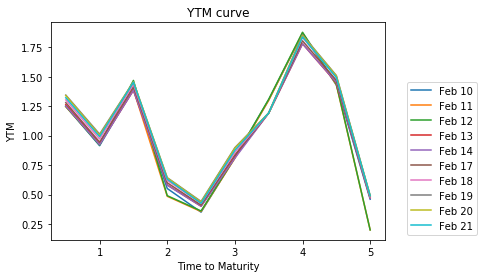

In [25]:
# load the data of chosen bonds
bonds = pd.read_excel (r'CHOSENBOND.xlsx') 

# format the issue date and the maturity date
bonds['issue date'] = pd.to_datetime(bonds['issue date'])
bonds['maturity date'] = pd.to_datetime(bonds['maturity date'])
mature_list = bonds['maturity date']
coupon_list = bonds['Coupon']
coupon = list(coupon_list)

# calculate the T for each chosen date
selected_ISINs = ["CA135087L930","CA135087K940","CA135087J967","CA135087M359","CA135087L286",
                  "CA135087L518","CA135087K528","CA135087J546","CA135087H490","CA135087G328"]
chosen_time_list = ['2022-01-10', '2021-01-11', '2021-01-12','2021-01-13', '2021-01-14', '2021-01-17', 
                    '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21']
chosen_time_list_2 = ["Feb 10", "Feb 11","Feb 12","Feb 13","Feb 14","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21"]
time_gap = list(np.linspace(0.5, 5, 10))
chosen_time_list = list(bonds.columns)[5:15]
T_list = []
for i in range(10):
    t = pd.to_datetime(chosen_time_list[i])
    temp= []
    for item in bonds["maturity date"]:
        T_cal = (item - t).days // 180 + 1
        temp.append(int(T_cal))
    T_list.append(temp)

freq = 2.0
notioanl = 100

import scipy.optimize as optimize
# get ytm for each chosen date
def get_price(coupon, ytm, freq, t):
    price_value = coupon/(1+ytm/freq)**(freq*t)
    return price_value

def get_accured(notional, ytm, freq,T):
    notional_price = notional/(1+ytm/freq)**(freq*T)
    return notional_price

def get_ytm(notional, T, coup, price, freq=2.0, guess=0.05):
    coupon = coup/freq*100
    t_list = []
    for i in range(int(T*freq)):
        temp_t = (i+1)/freq
        t_list.append(temp_t)
    ytm = lambda x: sum([get_price(coupon, x, freq, t) for t in t_list]) + get_accured(notional, x, freq, T) -price
    ytm = optimize.newton(ytm, guess) *100
    return ytm

# get ytm for each chosen date
ytm=[]
for i in range(10):
    ytm_temp = []
    price_lst = bonds[chosen_time_list[i]]
    T_val = T_list[i]
    for j in range(len(coupon)):
        cur_ytm = get_ytm(notioanl, T_val[j], coupon[j], price_lst[j])
        ytm_temp.append(cur_ytm)
    ytm.append(ytm_temp)

# plot the ytm 
for i in range(10):
    plt.plot(time_gap, ytm[i],label = str(chosen_time_list_2[i]))
plt.xlabel("Time to Maturity")
plt.ylabel("YTM")
# plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05,0), loc=3)
plt.title("YTM curve")




Text(0.5, 1.0, 'Spot Rate curve')

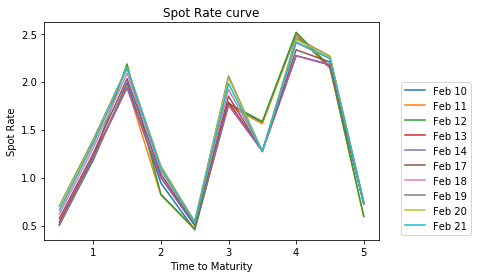

In [39]:
def spot_rate_no_coupon(price, notional, T):
    spot = - math.log(price / notional)/T
    return spot * 100
    
def spot_rate_with_coupon(price, notional, spot_data, t1, t2, coupon):
    p1 = coupon * notional
    p2 = (1 + coupon) * notional
    spot = - math.log((price - p1 * math.exp(-spot_data * t1)) / p2) / t2
    return spot

def get_dirty_price(n, coupon, notional, clean_price):
    accured_interest = n / 365 * coupon * notional
    dirty_price = accured_interest + clean_price
    return dirty_price

from copy import deepcopy
notional = 100
# calculate the spot rate for the first data without coupon
spot_rate = []
spot_1 = []
for i in range(10):
    T = (mature_list[0]- chosen_time_list[i]).days / 365
    price = bonds[chosen_time_list[i]][0]
    spot_rate_temp = spot_rate_no_coupon(price, notional, T)
    spot_rate.append([spot_rate_temp])
# calculate the following chosen time with coupon taken into consideration
spot_1 = spot_rate.copy()
for i in range(10):
    temp_spot = spot_rate[i][0]
    for j in range(9):
        temp_time = chosen_time_list[i] if j==0 else mature_list[j - 1]    
        t1 = (mature_list[j] - temp_time).days /365
        t2 = (mature_list[j+1] - temp_time).days /365
        clean_price = bonds[chosen_time_list[i]][j+1] 
        n = (mature_list[j+1] -  mature_list[j]).days
        dirty_price = get_dirty_price(n, coupon_list[j+1], notional, clean_price)
        spot = spot_rate_with_coupon(dirty_price, notioanl, temp_spot, t1, t2, coupon_list[j+1])
        temp_spot = spot
        spot_rate[i].append(abs(temp_spot) * 100)

# plot the splot rate
for i in range(10):
    plt.plot(time_gap, spot_rate[i],label = chosen_time_list_2[i])
plt.xlabel("Time to Maturity")
plt.ylabel("Spot Rate")
plt.legend(bbox_to_anchor=(1.05,0), loc=3)
plt.title("Spot Rate curve")

Text(0.5, 1.0, 'Forward Rate Curve')

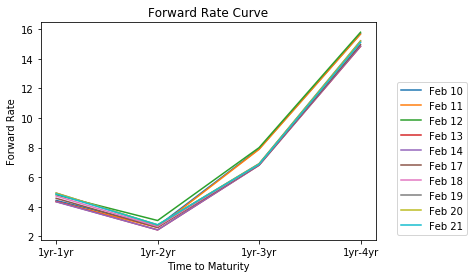

In [38]:
# get forward rate
def get_forward_rate(spot_rate):
    bond_index = 0
    forward_rate_list = []
    for i in range(4):
        spot1 = spot_rate[(i +1) * 2]/100
        spot2 = spot_rate[i * 2]/100
        forward_rate = (1+spot1)**(bond_index+2)/(1+spot2)**(bond_index+1) - 1
        forward_rate_list.append(abs(forward_rate) * 100)
        bond_index += 1
    return forward_rate_list

forward_rate = []
for i in range(10):
    forward_rate_temp = get_forward_rate(spot_rate[i])
    forward_rate.append(forward_rate_temp)

# plot the forward rate
year_gap = ["1yr-1yr", "1yr-2yr","1yr-3yr", "1yr-4yr"]
for i in range(10):
    plt.plot(year_gap, forward_rate[i],label= chosen_time_list_2[i])
plt.xlabel("Time to Maturity")
plt.ylabel("Forward Rate")
plt.legend(bbox_to_anchor=(1.05,0), loc=3)
plt.title("Forward Rate Curve")

In [30]:
# cov matrix for ytm
ytm_log_matrix = np.zeros([9, 5])
for i in range(5):
    for j in range(9):
        ytm_log_matrix[j, i] = math.log((ytm[j+1][i*2]) / (ytm[j][i*2]))
ytm_cov_matrix = np.cov(ytm_log_matrix.T)
ytm_eig_val, ytm_eig_vec = np.linalg.eig(ytm_cov_matrix)
print("covariance matrix")
print(ytm_cov_matrix)
print("eigenvalue")
print(ytm_eig_val)
print("eigenvector")
print(ytm_eig_vec)

covariance matrix
[[ 2.32672447e-04  6.46583476e-05  3.25945723e-04 -5.73991296e-05
   9.86681234e-05]
 [ 6.46583476e-05  9.08715344e-04 -5.90301589e-04  7.79602308e-04
   3.88539929e-05]
 [ 3.25945723e-04 -5.90301589e-04  1.39918821e-03 -9.86620633e-04
   1.74457707e-04]
 [-5.73991296e-05  7.79602308e-04 -9.86620633e-04  9.86314988e-04
  -2.41348507e-05]
 [ 9.86681234e-05  3.88539929e-05  1.74457707e-04 -2.41348507e-05
   6.35592395e-05]]
eigenvalue
[2.73270080e-03 7.10221983e-04 1.13194877e-04 2.90688272e-05
 5.26374337e-06]
eigenvector
[[-0.0896657   0.47257319  0.59632414 -0.63717275  0.08392289]
 [ 0.45945227  0.64018646 -0.59588829 -0.1383767   0.06952653]
 [-0.6625393   0.52324675 -0.0773925   0.35725631 -0.39196026]
 [ 0.58297695  0.18179478  0.48958732  0.45506508 -0.42462756]
 [-0.04520208  0.2449477   0.20887632  0.49004743  0.80881494]]


In [31]:
# cov matrix for forward rate
forward_log_matrix = np.zeros([9, 4])
for i in range(4):
    for j in range(9):
        forward_log_matrix[j, i] = math.log((forward_rate[j+1][i]) / (forward_rate[j][i]))
forward_cov_matrix = np.cov(forward_log_matrix.T)
forward_eig_val, forward_eig_vec = np.linalg.eig(forward_cov_matrix)
print("foward rate covariance matrix")
print(forward_cov_matrix)
print("forward rate eigenvalue")
print(forward_eig_val)
print("forward rate eigenvector")
print(forward_eig_vec)


foward rate covariance matrix
[[0.00311668 0.005695   0.00244553 0.00105007]
 [0.005695   0.01110749 0.00512735 0.00211604]
 [0.00244553 0.00512735 0.00299785 0.00121755]
 [0.00105007 0.00211604 0.00121755 0.00050782]]
forward rate eigenvalue
[1.68915249e-02 7.29588755e-04 1.05437396e-04 3.29044297e-06]
forward rate eigenvector
[[ 0.41489662  0.45080133  0.75780871 -0.2244213 ]
 [ 0.80858839  0.21511464 -0.53106694  0.13371018]
 [ 0.38542428 -0.81576098  0.15508739 -0.40240533]
 [ 0.15966754 -0.29161255  0.34589273  0.87739764]]
